In [92]:
import json
from datetime import datetime, timedelta
import calendar
from pytz import timezone
import pandas as pd
import plotnine as p9
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
with open('data.json') as f: 
    my_data = json.load(f)

In [3]:
layer_one = my_data.keys()
for key in layer_one:
    print(key)
    if isinstance(my_data[key], dict):
        print(my_data[key].keys())

Photos
Spotify
dict_keys(['spotify_connected'])
Purchases
dict_keys(['subscription', 'consumable', 'boost_tracking', 'super_like_tracking'])
Campaigns
dict_keys(['current_campaigns', 'expired_campaigns'])
Usage
dict_keys(['app_opens', 'swipes_likes', 'swipes_passes', 'matches', 'messages_sent', 'messages_received'])
Messages
User
dict_keys(['active_time', 'age_filter_max', 'age_filter_min', 'bio', 'birth_date', 'connection_count', 'create_date', 'education', 'email', 'full_name', 'gender', 'gender_filter', 'interested_in', 'interests', 'jobs', 'name', 'pos', 'schools', 'phone_id', 'college'])
StudentVerifications
dict_keys(['entries'])


In [4]:
def find_total_usage(key_col, to_print=False):
    total = 0
    for key, val in my_data['Usage'][key_col].items():
        total += val
    if to_print:
        print("Total " + key_col + ": " + str(total))
    else:
        return total

In [5]:
for item in my_data['Usage']:
    find_total_usage(item, True)

Total app_opens: 2687
Total swipes_likes: 1110
Total swipes_passes: 1791
Total matches: 672
Total messages_sent: 1146
Total messages_received: 2262


In [6]:
usage_dict = {}
for item in my_data['Usage']:
    for key in my_data['Usage'][item]:
        usage_dict[key] = []

topic_lst = []
for topic in my_data['Usage']:
    for date in usage_dict:
        if date in my_data['Usage'][topic].keys():
            usage_dict[date].append(int(my_data['Usage'][topic][date]))
        else:
            usage_dict[date].append(0)
    topic_lst.append(topic)

In [7]:
dates_df = pd.DataFrame(usage_dict)
cols_d = {key: val for (key, val) in zip(dates_df.T.columns, topic_lst)}
use_df = dates_df.T.rename(columns=cols_d).reset_index().rename(columns={'index': 'date'})
use_df['date'] = pd.to_datetime(use_df['date'])
use_df = use_df[use_df['date'] > datetime.strptime('2018-08-01', '%Y-%m-%d')]
use_df['month'] = use_df['date'].dt.month
use_df['month'] = use_df['month'].apply(lambda x: calendar.month_name[x])
use_df['day'] = use_df['date'].dt.day
use_df.head()

,date,app_opens,swipes_likes,swipes_passes,matches,messages_sent,messages_received,month,day
21,2018-08-25,160,51,22,22,136,263,August,25
22,2018-08-26,14,10,11,5,5,13,August,26
23,2018-08-27,9,14,11,6,0,4,August,27
24,2018-08-28,46,61,45,26,16,20,August,28
25,2018-08-29,193,56,40,24,109,160,August,29


In [34]:
melted_use = pd.melt(use_df, id_vars=['date', 'month', 'day'])
melted_use.head()

,date,month,day,variable,value
0,2018-08-25,August,25,app_opens,160
1,2018-08-26,August,26,app_opens,14
2,2018-08-27,August,27,app_opens,9
3,2018-08-28,August,28,app_opens,46
4,2018-08-29,August,29,app_opens,193


/Users/katykoeing/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


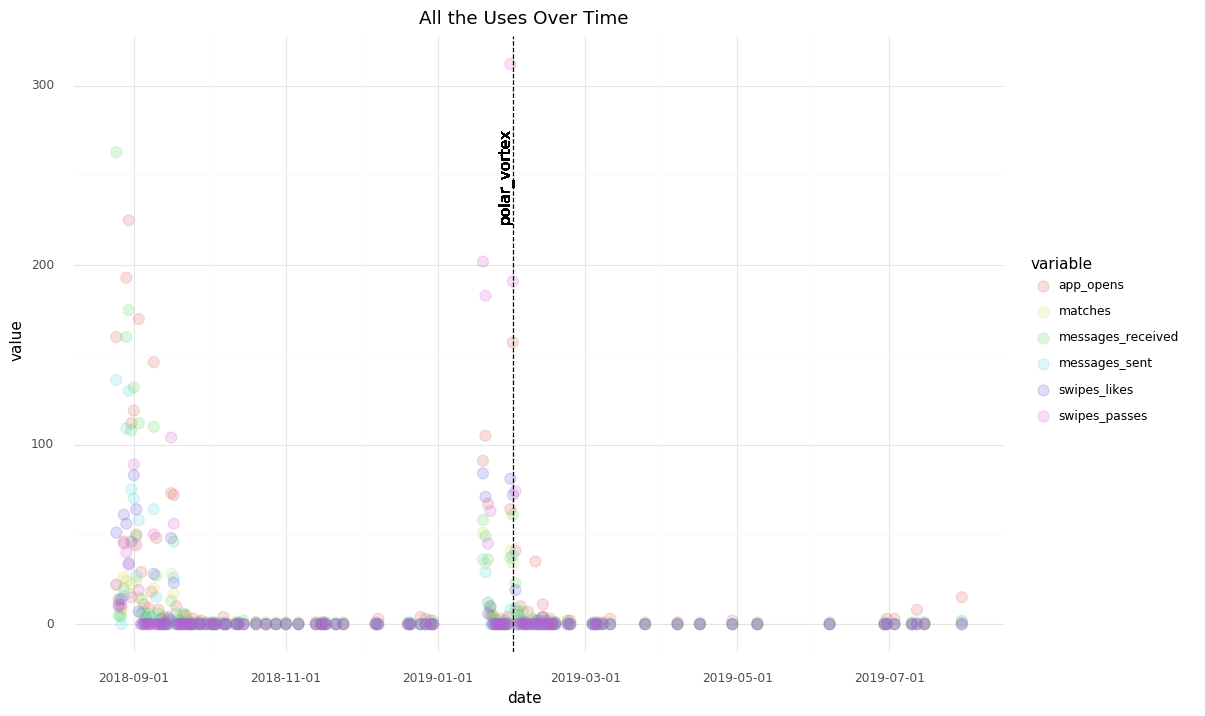

<ggplot: (-9223372036556435105)>

In [91]:
polar_v = datetime.strptime('2019-01-31', '%Y-%m-%d')
polar_vortex = 'polar_vortex'
p9.ggplot(melted_use, p9.aes('date', 'value', col='variable')) + \
          p9.geom_point(p9.aes(color='variable'), alpha=0.2, size=4) + p9.theme_minimal() + \
          p9.geom_vline(xintercept=polar_v, linetype='dashed') + \
          p9.theme(figure_size=(12, 8)) + \
          p9.geom_text(p9.aes(x=(polar_v + timedelta(days=-3)), label=polar_vortex, y=250), angle=90) + \
          p9.ggtitle('All the Uses Over Time')

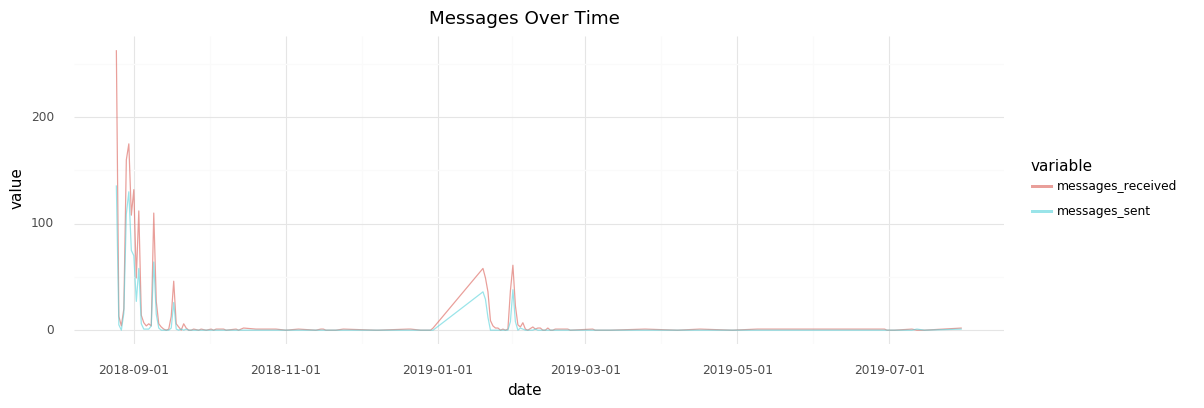

<ggplot: (-9223372036559783494)>

In [36]:
melted_messages = melted_use[melted_use['variable'].isin(['messages_sent', 'messages_received'])]
p9.ggplot(melted_messages, p9.aes('date', 'value', col='variable')) + \
          p9.geom_line(p9.aes(color='variable'), alpha=0.6) + p9.theme_minimal()+ \
          p9.theme(figure_size=(12, 4)) + p9.ggtitle('Messages Over Time')

In [37]:
count = 0
for message in my_data['Messages']:
    if not message['messages']:
        count += 1
print("Number of Unrequited Initial Buddings of Love: {}".format(count))
print("Probability I would actually respond to a first message: {:.2f}%".format(count / len(my_data['Messages']) * 100))
print("¯\_(ツ)_/¯")

Number of Unrequited Initial Buddings of Love: 165
Probability I would actually respond to a first message: 53.05%
¯\_(ツ)_/¯


In [38]:
daydayday = datetime.strptime(my_data['Messages'][0]['messages'][0]['sent_date'][5:16], '%d %b %Y')
total_days =  daydayday - datetime.strptime(min(my_data['Usage']['app_opens'], key=my_data['Usage']['app_opens'].get), '%Y-%m-%d')
print(f"Num days w/ app til \"meet\" SUPER CUTE: {total_days.days} !!!!!")

Num days w/ app til "meet" SUPER CUTE: 473 !!!!!


In [39]:
message_d = {'num_words': [], 'date': [], 'dow': []}
for messenger in my_data['Messages']:
    convo = messenger['messages']
    for i in range(len(convo)):
        message_d['num_words'].append(len(convo[i]['message'].split()))
        message_d['date'].append(datetime.strptime(convo[i]['sent_date'][5:-4], '%d %b %Y %H:%M:%S').replace(tzinfo=timezone('GMT')))
        message_d['dow'].append(convo[i]['sent_date'][:3])
message_df = pd.DataFrame(message_d)
message_df['time'] = message_df['date'].apply(lambda x: x.astimezone('US/Central').time())
message_df['date'] = message_df['date'].apply(lambda x: x.astimezone('US/Central').date())
message_df['hour'] = message_df['time'].apply(lambda x: x.hour)
message_df['tod'] = pd.cut(message_df['hour'], bins=[6, 12, 17, 23],
                    labels=['morning','afternoon','night'])
message_df['tod'] = message_df['tod'].astype('str')
message_df['tod'].replace('nan', 'late_night', inplace=True)
message_df['weekday'] = ~message_df['dow'].isin(['Fri', 'Sat', 'Sun'])
message_df['date'] = pd.to_datetime(message_df['date'])
message_df.head(n=10)

,num_words,date,dow,time,hour,tod,weekday
0,11,2019-01-30,Thu,19:54:58,19,night,True
1,26,2019-01-31,Thu,10:50:16,10,morning,True
2,7,2019-01-31,Thu,10:50:37,10,morning,True
3,23,2019-01-31,Fri,18:43:21,18,night,False
4,28,2019-01-31,Fri,18:45:24,18,night,False
5,10,2019-02-01,Fri,10:52:11,10,morning,False
6,19,2019-02-02,Sun,18:58:38,18,night,False
7,11,2019-02-03,Sun,14:51:13,14,afternoon,False
8,4,2019-02-04,Mon,07:17:56,7,morning,True
9,6,2019-07-12,Fri,09:44:37,9,morning,False


/Users/katykoeing/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


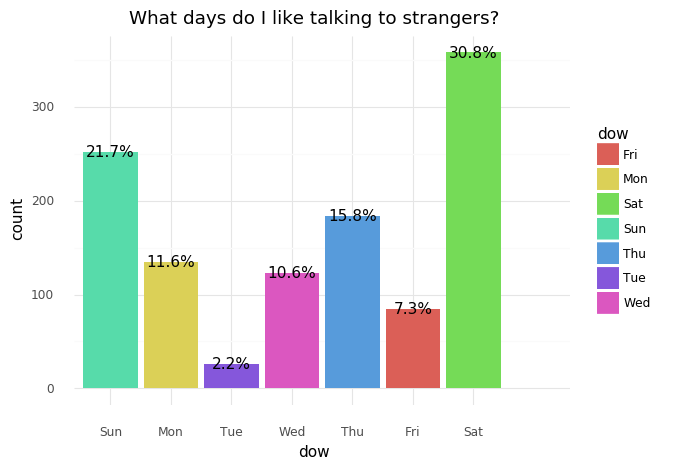

<ggplot: (296631963)>

In [40]:
p9.ggplot(message_df, p9.aes('dow', fill='dow')) + p9.geom_bar() + \
          p9.geom_text(p9.aes(label='stat(prop)*100', group=1),
                       stat='count', format_string='{:.1f}%') + \
          p9.scale_x_discrete(limits=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) + \
          p9.theme_minimal() + p9.ggtitle('What days do I like talking to strangers?')

Bins:
* Morning 6:00:01 - 12:00:00
* Afternoon 12:00:01 - 17:00:00
* Night 17:00:01 - 23:00:00
* Late Night 23:00:01 - 6:00:00

/Users/katykoeing/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


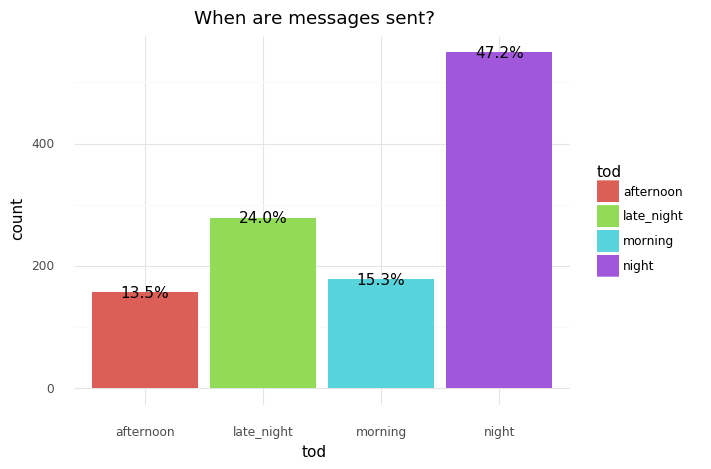

<ggplot: (-9223372036562896752)>

In [41]:
p9.ggplot(message_df, p9.aes('tod', fill='tod')) + p9.geom_bar() + \
          p9.geom_text(p9.aes(label='stat(prop)*100', group=1),
                       stat='count', format_string='{:.1f}%') + \
          p9.theme_minimal() + p9.ggtitle('When are messages sent?')

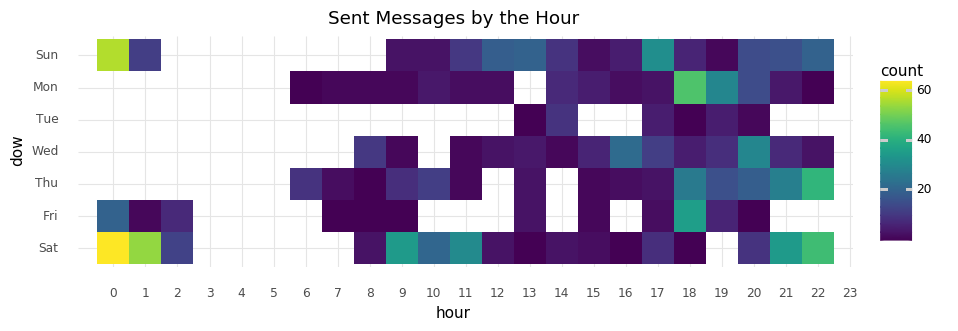

<ggplot: (-9223372036557829309)>

In [53]:
p9.ggplot(message_df) + p9.aes('hour', 'dow') + p9.geom_bin2d(bins=24) + \
p9.scale_y_discrete(limits=['Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon', 'Sun']) + \
p9.scale_x_discrete(breaks=np.arange(0, 24), limits=np.arange(0, 24)) + \
p9.ggtitle('Sent Messages by the Hour') + p9.theme_minimal() + p9.theme(figure_size=(10, 3)) 

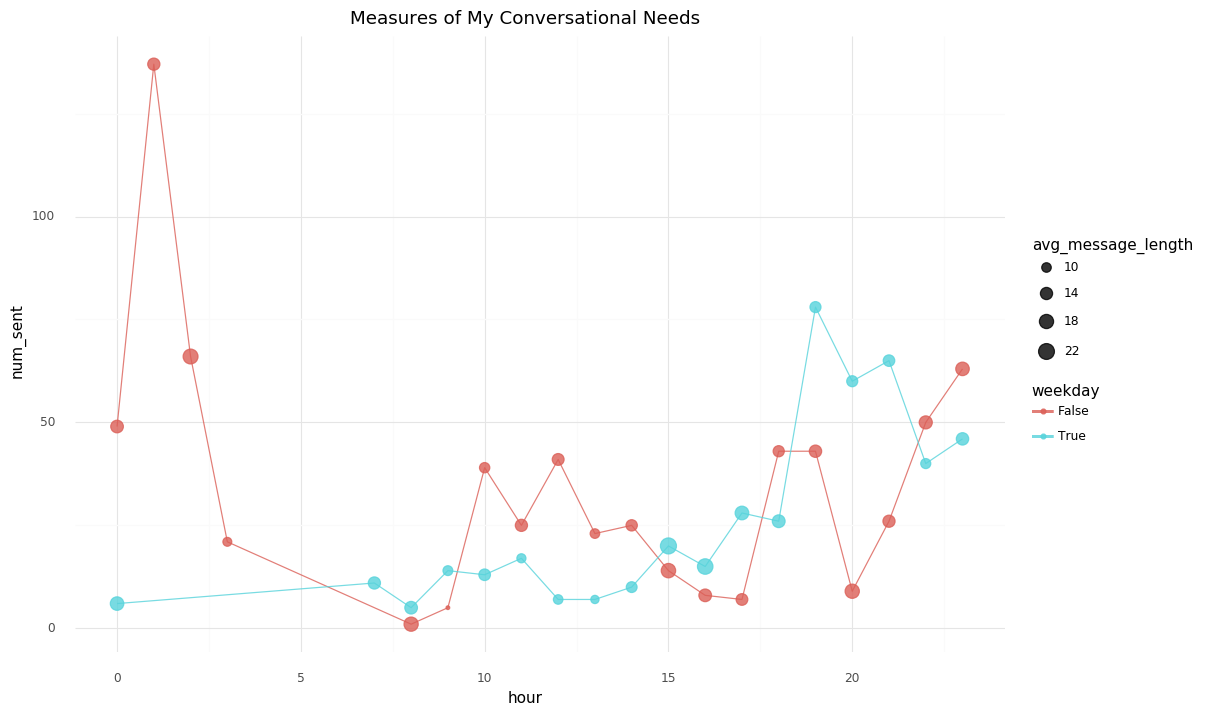

<ggplot: (-9223372036559852863)>

In [18]:
messages_grouped = message_df.groupby(['hour', 'weekday'])['num_words'].agg(['mean', 'count']).reset_index()
melted_messages = pd.melt(messages_grouped, id_vars=['hour', 'mean', 'count']).rename(columns={'value':'weekday', 'count': 'num_sent', 'mean': 'avg_message_length'})
p9.ggplot(melted_messages, p9.aes('hour', 'num_sent')) + p9.geom_point(p9.aes(color='weekday', size='avg_message_length'), alpha=0.8) + \
          p9.geom_line(p9.aes(color='weekday'), alpha=0.8) + p9.theme_minimal() + p9.theme(figure_size=(12, 8)) + p9.ggtitle('Measures of My Conversational Needs')

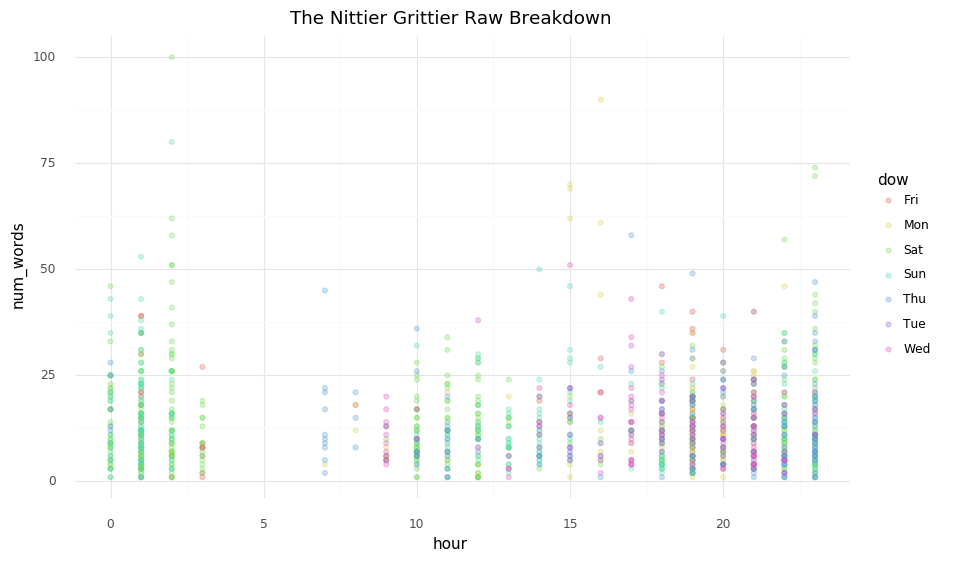

<ggplot: (-9223372036559050983)>

In [19]:
p9.ggplot(message_df, p9.aes('hour', 'num_words')) + \
p9.geom_point(p9.aes(color='dow'), alpha=0.3) + \
p9.theme_minimal() + p9.theme(figure_size=(10, 6)) + p9.ggtitle('The Nittier Grittier Raw Breakdown')

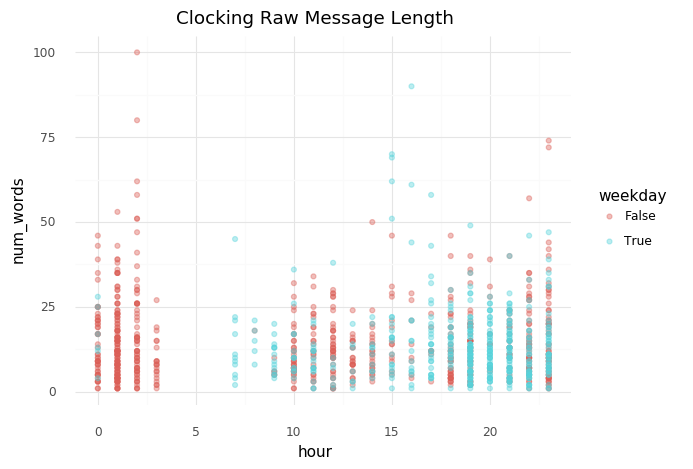

<ggplot: (-9223372036559053985)>

In [20]:
p9.ggplot(message_df, p9.aes('hour', 'num_words')) + \
p9.geom_point(p9.aes(color='weekday'), alpha=0.4) + \
p9.theme_minimal() + p9.ggtitle('Clocking Raw Message Length')

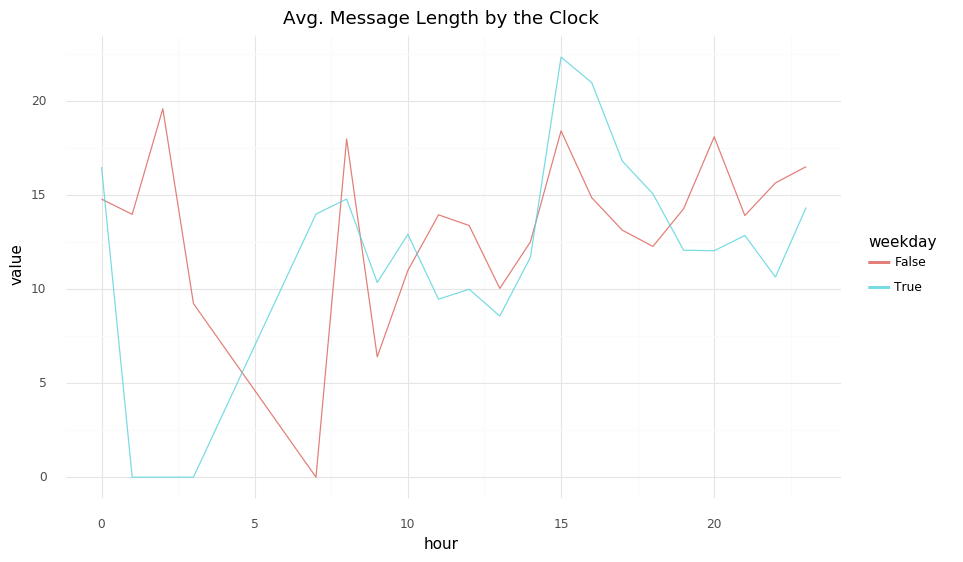

<ggplot: (294470776)>

In [83]:
melted_by_dt = pd.melt(message_df.groupby(['hour', 'weekday'])['num_words'].mean().unstack().reset_index().fillna(0), id_vars=['hour'])
p9.ggplot(melted_by_dt, p9.aes('hour', 'value')) + p9.geom_line(p9.aes(color='weekday'), alpha=0.8) + \
          p9.theme_minimal() + p9.theme(figure_size=(10, 6)) + p9.ggtitle('Avg. Message Length by the Clock')

In [166]:
messages_by_hr = message_df.groupby('hour').agg({'num_words': 'mean', 'tod': 'count'}).rename({'tod': 'count'}, axis=1).reset_index()
hours = pd.DataFrame(np.arange(0, 25)).rename({0: 'hour'}, axis=1)
total_hours = pd.merge(hours, messages_by_hr, on='hour', how='left').fillna(0)

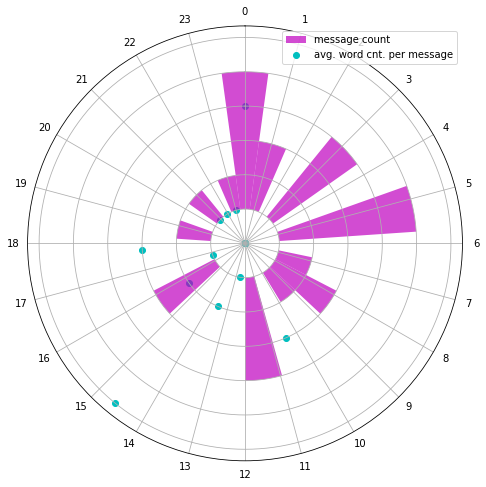

In [164]:
theta = np.linspace(0.0, 2 * np.pi, 23, endpoint=False)
radii, _ = np.histogram(total_hours['count'], bins = 23)
radii2, _ = np.histogram(total_hours['num_words'], bins = 23)
bar_width = (2*np.pi) / 23
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=bar_width, bottom=1, alpha=0.7, color='m')
points = ax.scatter(theta, radii2, alpha=1, color='c')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))
plt.legend([bars, points],['message count', 'avg. word cnt. per message'])
plt.show()

In [80]:
# This fills in any empty dates
dates = pd.DataFrame(pd.date_range('2018-08-25', '07-24-2019')).rename({0: 'date'}, axis=1)
total_dates = pd.merge(dates, by_date, on='date', how='left')
int_cols = [] 
for col in total_dates.columns:
    if total_dates[col].dtype == 'float64' and col != 'day':
        int_cols.append(col)
total_dates[int_cols] = total_dates[int_cols].fillna(0).astype('int')
total_dates['month'] = total_dates['date'].dt.month
total_dates['month'] = total_dates['month'].apply(lambda x: calendar.month_name[x])
total_dates['day'] = total_dates['date'].dt.day
total_dates['dow'] = total_dates['date'].dt.weekday_name
total_dates['dow'] = total_dates['dow'].apply(lambda x: x[:3])
total_dates.head()

,date,app_opens,swipes_likes,swipes_passes,matches,messages_sent,messages_received,month,day,dow,num_words,weekday
0,2018-08-25,160,51,22,22,136,263,August,25,Sat,14,False
1,2018-08-26,14,10,11,5,5,13,August,26,Sun,7,False
2,2018-08-27,0,0,0,0,0,0,August,27,Mon,0,NaN
3,2018-08-28,46,61,45,26,16,20,August,28,Tue,11,True
4,2018-08-29,193,56,40,24,109,160,August,29,Wed,13,True


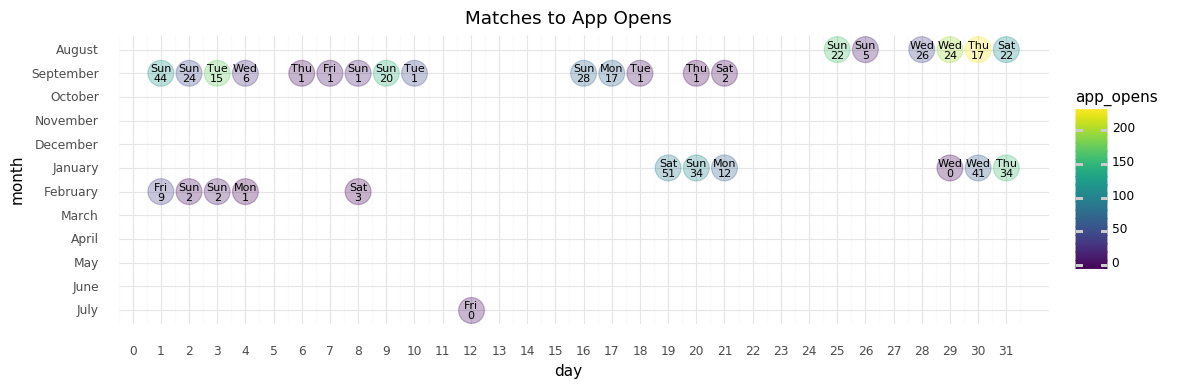

<ggplot: (294880818)>

In [81]:
#inspired by https://chichacha.netlify.com/2018/05/26/making-calendar-with-ggplot-moon-phase-calendar/
p9.ggplot(by_date, p9.aes(x="day", y="month")) + p9.theme_minimal() + \
p9.scale_x_continuous(breaks=np.arange(0, 32)) + \
p9.geom_point(p9.aes(color='app_opens'), alpha=0.3, size=10) + \
p9.geom_text(p9.aes(label="matches"), va='top', size=8) + p9.theme(figure_size=(12, 3.75)) + \
p9.geom_text(p9.aes(label='dow'), size=8, va='bottom') + \
p9.scale_y_discrete(limits=['July', 'June', 'May', 'April', 'March', 'February', 'January', 'December', 'November',
                            'October', 'September', 'August']) + \
p9.labs(title="Matches to App Opens")

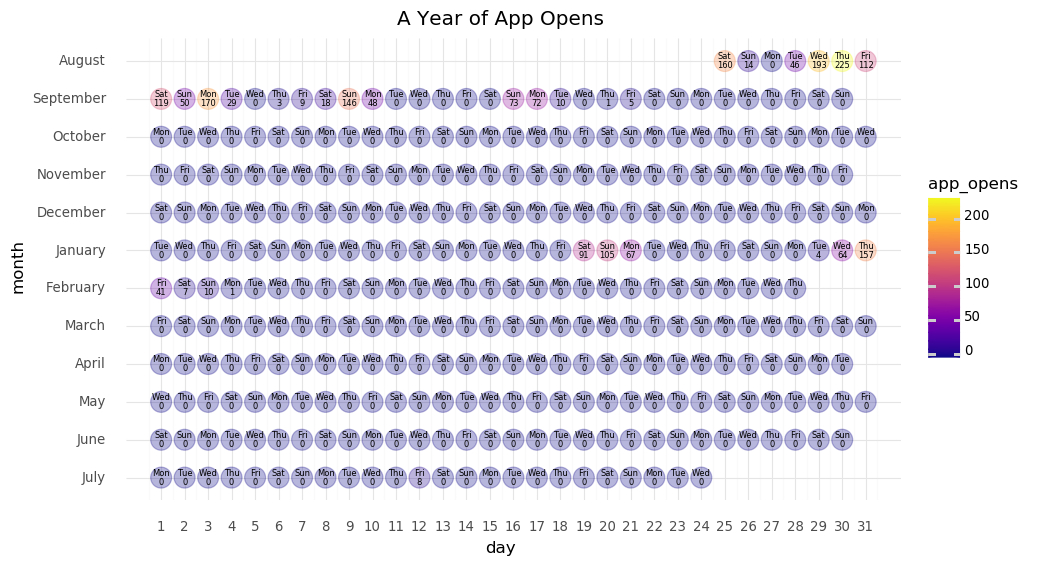

<ggplot: (-9223372036559800993)>

In [82]:
p9.ggplot(total_dates, p9.aes(x="day", y="month")) + p9.theme_minimal(base_size=12) + \
p9.scale_x_continuous(breaks=np.arange(1, 32)) + \
p9.geom_point(p9.aes(color='app_opens'), alpha=0.3, size=8) + \
p9.geom_text(p9.aes(label="app_opens"), va='top', size=6) + p9.theme(figure_size=(10, 6)) + \
p9.geom_text(p9.aes(label='dow'), size=6, va='bottom') + \
p9.scale_y_discrete(limits=['July', 'June', 'May', 'April', 'March', 'February', 'January', 'December', 'November',
                            'October', 'September', 'August']) + \
p9.labs(title="A Year of App Opens") + p9.scale_color_cmap('plasma')